# EIT - Digitale tvillinger - Gruppe 5
# Nevralt nettverk for gjennkjenning av kumlokk


### Installing Requirements

In [405]:
!pip install matplotlib numpy albumentations tensorflow

### Importing dependencies

In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import albumentations as alb
import cv2

In [406]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [407]:
tf.config.list_physical_devices('GPU')

[]

### Laste ut filer til datastream

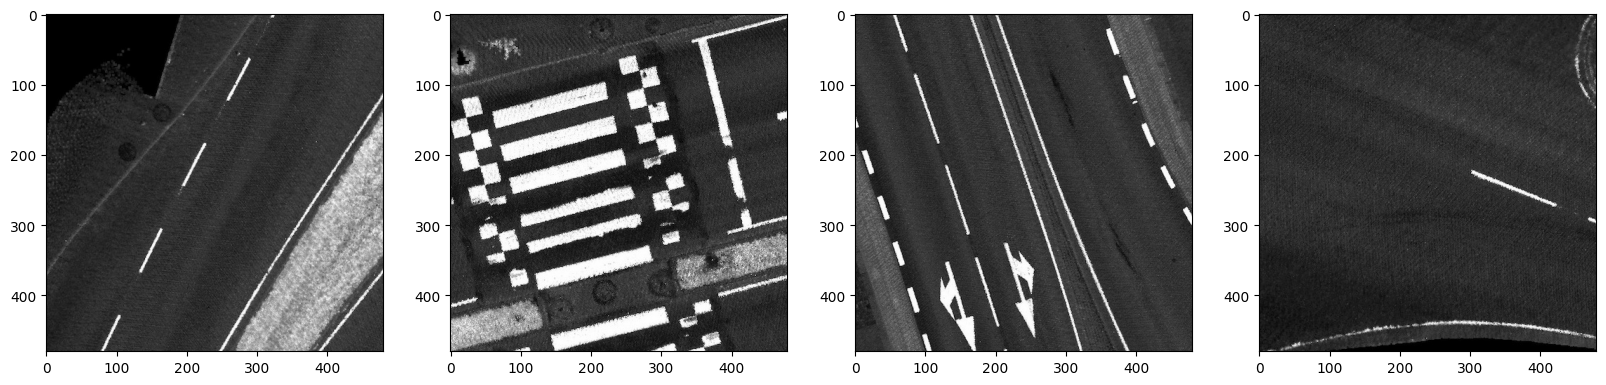

In [74]:
images = tf.data.Dataset.list_files('data\\all\\images\\*.jpeg')


def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img, channels=1)
    return tf.image.grayscale_to_rgb(img)

images = images.map(load_image)


image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
plot_images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### Kjører på med 70% train (59), 15% test (13), 15% val (12).

In [250]:
for folder in ['train','test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'all', 'labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

### Lager en image augmentor. Kjører på med randoom cropping, litt brigtness endringer, gamma endringer og speiling

In [379]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5),
                         alb.RandomGamma(p=0.2),
                         alb.RandomBrightnessContrast(p=0.3, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1)),
                         alb.VerticalFlip(p=0.5), 
                        alb.Rotate(p=0.4), 
                        alb.RandomCrop(width=480, height=480, p=0.3)],
                       keypoint_params=alb.KeypointParams(format='xy'))


In [380]:
img = cv2.imread(os.path.join('data','train', 'images','Rogaland_TrueRoad_000454.jpeg'))

with open(os.path.join('data', 'train', 'labels', 'Rogaland_TrueRoad_000454.json'), 'r') as f:
    label = json.load(f)
    
len(label['shapes'])


2

### Fikser label coordinater, så de er relative til oppløsningen

[(317, 207), (325, 217), (377, 188), (383, 198)]
circle 0 (317, 272) 12
circle 1 (377, 291) 11


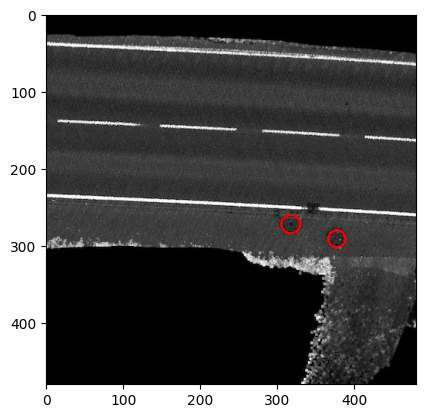

In [381]:
coords = []
for kum_nr in range(len(label['shapes'])):
    coords.append((int(label['shapes'][kum_nr]['points'][0][0]), int(label['shapes'][kum_nr]['points'][0][1])))
    coords.append((int(label['shapes'][kum_nr]['points'][1][0]), int(label['shapes'][kum_nr]['points'][1][1])))
print(coords)
def get_radius_from_points(center, edge):
    return np.sqrt((center[0] - edge[0])**2 + (center[1] - edge[1])**2)

augmented = augmentor(image=img, keypoints=coords)

for i in range(len(coords)//2):
    cv2.circle(augmented['image'], 
                  augmented['keypoints'][i*2],
                  int(get_radius_from_points(augmented['keypoints'][i*2],
                  augmented['keypoints'][i*2+1])), 
                        (255,0,0), 2)
    print("circle", i, augmented['keypoints'][i*2],
                  int(get_radius_from_points(augmented['keypoints'][i*2],
                  augmented['keypoints'][i*2+1])))

plt.imshow(augmented['image'])

### Run augmentation for all data.

In [382]:

for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = []
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            for kum_nr in range(len(label['shapes'])):
                coords.append((int(label['shapes'][kum_nr]['points'][0][0]), int(label['shapes'][kum_nr]['points'][0][1])))
                coords.append((int(label['shapes'][kum_nr]['points'][1][0]), int(label['shapes'][kum_nr]['points'][1][1])))
      

        for x in range(80):
            augmented = augmentor(image=img, keypoints=coords)
            if len(augmented['keypoints'])%2 == 1:
                    print("Lost keypoint")
                    continue
                    
            cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpeg'), augmented['image'])

            annotation = {}
            annotation['image'] = image
            bcircle = []

            if os.path.exists(label_path):
                if len(augmented['keypoints']) == 0: 
                    annotation['bcircle'] = [(0,0),(0,0)]
                    annotation['class'] = 0 
                else:
                    if isinstance(augmented['keypoints'][0][0], int):
                        bcircle = augmented['keypoints']
                    else:
                        for point in augmented['keypoints']:
                            bcircle.append((int(point[0]), int(point[1])))            
                                           
                    annotation['bcircle'] = bcircle
                    annotation['class'] = len(label['shapes'])
            else: 
                annotation['bcircle'] = [(0,0),(0,0)]
                annotation['class'] = 0 

            with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                json.dump(annotation, f)



Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint
Lost keypoint


### Laste in augmenterte bilder til tensorflow dataset.

In [10]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpeg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: x/255) 

NameError: name 'tf' is not defined

In [384]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpeg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: x/255)

In [385]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpeg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: x/255)

In [386]:
train_images.as_numpy_iterator().next()

array([[[0.23921569, 0.23921569, 0.23921569],
        [0.19607843, 0.19607843, 0.19607843],
        [0.21176471, 0.21176471, 0.21176471],
        ...,
        [0.24313726, 0.24313726, 0.24313726],
        [0.21568628, 0.21568628, 0.21568628],
        [0.22745098, 0.22745098, 0.22745098]],

       [[0.21176471, 0.21176471, 0.21176471],
        [0.25490198, 0.25490198, 0.25490198],
        [0.16470589, 0.16470589, 0.16470589],
        ...,
        [0.24705882, 0.24705882, 0.24705882],
        [0.25882354, 0.25882354, 0.25882354],
        [0.23529412, 0.23529412, 0.23529412]],

       [[0.21176471, 0.21176471, 0.21176471],
        [0.22745098, 0.22745098, 0.22745098],
        [0.19215687, 0.19215687, 0.19215687],
        ...,
        [0.1882353 , 0.1882353 , 0.1882353 ],
        [0.22352941, 0.22352941, 0.22352941],
        [0.18431373, 0.18431373, 0.18431373]],

       ...,

       [[0.14901961, 0.14901961, 0.14901961],
        [0.14509805, 0.14509805, 0.14509805],
        [0.14901961, 0

### Behandle og legge inn labels

In [387]:
def get_radius_from_points(center, edge):
    return np.sqrt((center[0] - edge[0])**2 + (center[1] - edge[1])**2)

def load_labels(label_path):
    bcircle = [[0, 0, 0, 0]]*5
    curr_radius = 0
    curr_center = (0, 0)
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    for i in range(0, len(label['bcircle']), 2):
        curr_center = label['bcircle'][i]
        curr_radius = int(get_radius_from_points(label['bcircle'][i], label['bcircle'][i+1]))
        bcircle[i//2] = ([(curr_center[0]-curr_radius), (curr_center[1]-curr_radius), (curr_center[0]+curr_radius), (curr_center[1]+curr_radius)])  
        
    return [label['class']], bcircle


In [388]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [389]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([[249., 293., 285., 329.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]], dtype=float16))

### Sette inn i TF dataset 

In [9]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

NameError: name 'tf' is not defined

In [130]:
#train.as_numpy_iterator().next()

(array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          ...,
          [1.9889706e-01, 1.9889706e-01, 1.9889706e-01],
          [2.3198530e-01, 2.3198530e-01, 2.3198530e-01],
          [2.0000000e-01, 2.0000000e-01, 2.0000000e-01]],
 
         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          ...,
          [2.0022978e-01, 2.0022978e-01, 2.0022978e-01],
          [2.2265625e-01, 2.2265625e-01, 2.2265625e-01],
          [2.0355392e-01, 2.0355392e-01, 2.0355392e-01]],
 
         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          ...,
          [2.4472657e-01, 2.4472657e-01, 2.4472657e-01],
          [2.0152803e-01, 2.0152803e-

### se om ting blir riktig boxet

In [391]:
data_samples = train.as_numpy_iterator()

In [392]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


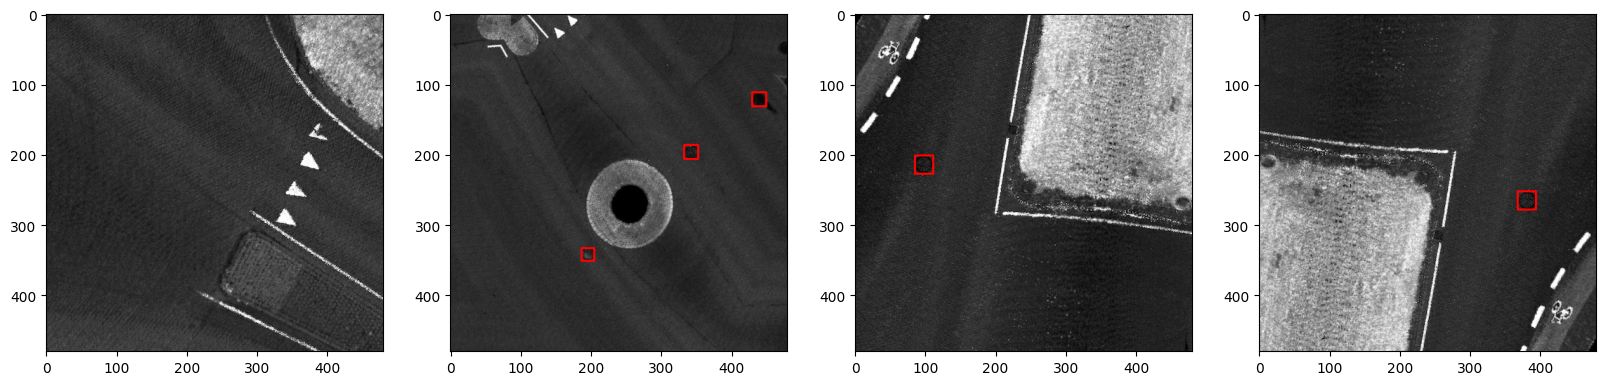

In [396]:
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    for i in range(res[1][0][idx][0]):
        cv2.rectangle(sample_image, 
                  tuple(sample_coords[i][:2].astype(int)),
                  tuple(sample_coords[i][2:].astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

### DEEP learning time!

### kjører på med VGG16

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [3]:
vgg = VGG16(include_top=False)

In [4]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [5]:
def build_model(): 
    input_layer = Input(shape=(480,480,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    kumlokkfinder = Model(inputs=input_layer, outputs=[class2, regress2])
    return kumlokkfinder

In [8]:
kumlokkfinder = build_model()
kumlokkfinder.summary()
X, y = train.as_numpy_iterator().next()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

NameError: name 'train' is not defined

In [7]:
X.shape

NameError: name 'X' is not defined

In [424]:
classes, coords = kumlokkfinder.predict(X)
classes, coords

1/1 [==============================] - 1s 1s/step


(array([[0.3001895 ],
        [0.39353347],
        [0.37563187],
        [0.36932608],
        [0.35644388],
        [0.39421162],
        [0.41499937],
        [0.4090862 ]], dtype=float32),
 array([[0.5204825 , 0.5955164 , 0.54854345, 0.60569936],
        [0.63353956, 0.51990473, 0.5237863 , 0.6317435 ],
        [0.49977487, 0.45639136, 0.48658147, 0.7087489 ],
        [0.5724363 , 0.5230497 , 0.54653716, 0.61368996],
        [0.6874202 , 0.5373151 , 0.552675  , 0.60188967],
        [0.6620671 , 0.53828764, 0.4902141 , 0.67503405],
        [0.60518837, 0.5359952 , 0.48916474, 0.5579845 ],
        [0.57983726, 0.50892204, 0.5356639 , 0.61929655]], dtype=float32))

### Lossfuntion and optimizers

In [402]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [408]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### lossfunction for kumlokkposisjon

In [429]:
def localization_loss_sub(y_true, yhat):
    print(y_true, yhat)
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    return delta_coord + delta_size

def localization_loss(y_true, yhat):
    return min(map(lambda x: localization_loss_sub(x, yhat),y_true))

### klasseloss, (antall kumlokk i bilde)

In [426]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [430]:
localization_loss(y[1], coords)


[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] [[0.5204825  0.5955164  0.54854345 0.60569936]
 [0.63353956 0.51990473 0.5237863  0.6317435 ]
 [0.49977487 0.45639136 0.48658147 0.7087489 ]
 [0.5724363  0.5230497  0.54653716 0.61368996]
 [0.6874202  0.5373151  0.552675   0.60188967]
 [0.6620671  0.53828764 0.4902141  0.67503405]
 [0.60518837 0.5359952  0.48916474 0.5579845 ]
 [0.57983726 0.50892204 0.5356639  0.61929655]]


ValueError: operands could not be broadcast together with shapes (5,2) (8,2) 